## Measure the Uptime Per Node
We want to make sure that the uptime workers are maintained

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import typing as t

from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path

FIGS_DIR: t.Final[Path] = Path("figures")
RUNS_DIR: t.Final[Path] = Path("../prod-runs")

FIGS_DIR.mkdir(exist_ok=True)

Config

In [ ]:
RESOURCE_TO_TASK: dict[str, tuple[str, str]] = {
    "Single Node": ("training", "train_generator"),
    "1 GPU": ("generation", "run_generator"),
    "<1 GPU": ("simulation", "run_molecular_dynamics"),
    "Multi Node": ("simulation", "run_optimization"),
}

## Get the Uptimes for Different Tasks
Show that everything is working as desired

In [4]:
def get_workers_by_type(path: Path) -> dict[str, int]:
    """Get the number of workers for each type of task"""

    node_names = []
    compute = json.loads((path / "compute-config.json").read_text())

    return {
        "Single Node": 1,
        "1 GPU": (len(compute["ai_hosts"]) - 1) * compute["gpus_per_node"],
        "<1 GPU": len(compute["lammps_hosts"])
        * compute["gpus_per_node"]
        * compute["lammps_per_gpu"],
        "Multi Node": len(compute["cp2k_hosts"]) // compute["nodes_per_cp2k"],
    }
    return compute


worker_counts = get_workers_by_type(RUNS_DIR / "450-nodes")
worker_counts

{'Single Node': 1, '1 GPU': 176, '<1 GPU': 2440, 'Multi Node': 50}

Count the number of active tasks for each task type

In [ ]:
def count_active_workers(
    path, worker_counts: dict[str, int]
) -> dict[str, pd.DataFrame]:
    """Count the number of active workers for each type of worker"""

    # Get the first
    start_time = np.inf
    for file in path.glob("*-results.json"):
        with open(file) as fp:
            for line in fp:
                record = json.loads(line)
                start_time = min(record["timestamp"]["created"], start_time)

    # Get the utilization for each task type
    output = {}
    for task_type, total_count in worker_counts.items():
        file_prefix, method_name = RESOURCE_TO_TASK[task_type]

        # Load the spans for each task
        tasks = []
        with open(path / f"{file_prefix}-results.json") as fp:
            # Gather the spans of all tasks
            for line in fp:
                record = json.loads(line)
                if record["method"] == method_name:
                    tasks.append(
                        {
                            "start_time": record["timestamp"]["compute_started"]
                            - start_time,
                            "end_time": record["timestamp"]["compute_ended"]
                            - start_time,
                        }
                    )
            tasks = pd.DataFrame(tasks)

            # Compute the number active
            events = [{"time": 0, "active_delta": 0}]
            events.extend({"time": t, "active_delta": -1} for t in tasks["end_time"])
            events.extend({"time": t, "active_delta": 1} for t in tasks["start_time"])
            events = pd.DataFrame(events).sort_values("time")

            # Compute the utilization
            events["num_active"] = events["active_delta"].cumsum()
            events["utilization"] = events["num_active"] / total_count

            output[task_type] = events
    return output


util_data = count_active_workers(RUNS_DIR / "450-nodes", worker_counts)

Plot the utilization by task type

In [9]:
def window_utilization(events, time: float, window_size) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate the pieces that fall within the window
    in_events = events[events.time <= time]
    in_events = in_events[in_events.time >= time - window_size]
    if len(in_events) <= 1:
        in_util = 0
    else:
        in_util = (
            np.diff(in_events["time"].values) * in_events["utilization"].values[:-1]
        ).sum()

        # Integrate the current piece (last in event to now)
        current_event = in_events.iloc[-1]
        current_util = (time - current_event.time) * current_event.utilization
        in_util += current_util

    # Integrate the piece at the start of the window
    before_window = events[events.time < time - window_size]
    if len(before_window) == 0:
        # No tasks, no utilization
        last_util = 0
    else:
        last_event = before_window.iloc[-1]
        if len(in_events) == 0:
            # That utilization, whole span
            return last_event.utilization
        else:
            # Get the span (start of window, first in event)
            last_even_span = in_events.iloc[0].time - (time - window_size)
            last_util = last_even_span * last_event.utilization

    return (in_util + last_util) / max(min(time, window_size), 1e-6)


window_utilization(util_data["Single Node"], 0, 5)

0.0

30 minute average uptime seems a good metric to me

## Plot as a Function of Scale
Do we keep workers equally busy as a function of scale?

In [10]:
summary = []
for path in Path("../prod-runs/").glob("*-nodes"):
    nodes = int(path.name.split("-")[0])
    me = {"nodes": nodes}

    # Load the utilization data
    worker_count = get_workers_by_type(path)
    for task_type, events in count_active_workers(path, worker_count).items():
        times = np.linspace(0, events["time"].max(), 2048)[1:]
        util = [window_utilization(events, t, window_size=60 * 60) for t in times]
        me[f"{task_type}-util"] = max(util)

    summary.append(me)
summary = pd.DataFrame(summary).sort_values("nodes")
summary

,nodes,Single Node-util,1 GPU-util,<1 GPU-util,Multi Node-util
0,128,0.998815,0.999941,0.999878,0.999971
1,256,0.998342,0.999928,0.999842,0.999964
2,450,0.997513,0.990044,0.999754,0.999951


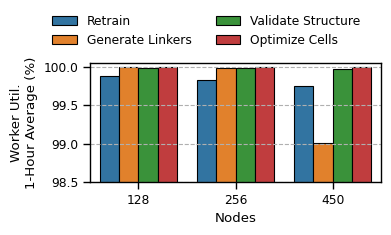

In [12]:
with sns.plotting_context("paper", font_scale=1.0):
    fig, ax = plt.subplots(figsize=(4, 3))

    markers = iter(["o", "v", "^", "s"])
    colors = iter(["darkorchid", "seagreen", "tomato", "darkgoldenrod"])

    tmp = summary.melt(
        id_vars=["nodes"],
        value_vars=["Single Node-util", "1 GPU-util", "<1 GPU-util", "Multi Node-util"],
        var_name="task",
        value_name="util",
    )
    tmp = tmp.replace(
        {
            "Single Node-util": "Retrain",
            "1 GPU-util": "Generate Linkers",
            "<1 GPU-util": "Validate Structure",
            "Multi Node-util": "Optimize Cells",
        }
    )
    tmp["util"] = tmp["util"] * 100

    sns.barplot(
        tmp,
        x="nodes",
        y="util",
        hue="task",
        edgecolor="black",
        ax=ax,
    )

    ax.set_xlabel("Nodes")
    ax.set_ylabel("Worker Util.\n1-Hour Average (%)")
    ax.grid(axis="y", linestyle="--")
    ax.set_ylim(98.5, 100.05)
    ax.legend(
        ncols=2,
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.4, 1.5),
    )

    plt.tight_layout()
    plt.savefig(FIGS_DIR / "fig3.pdf", bbox_inches="tight")
    plt.show()